## Install and import pyspark, create spark session
- I start by installing and importing spark and create spark session

In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 18.5 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=6bee9e598a3953a004fd368b550d31162b7d562ab97c5c57713d7368176fdf5d
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
import pyspark

In [3]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

## Read and merge all gas files
### Load & process gas price data with Spark

Then I load price data from 2019 to 2121 (3 years timespan) as well as 2022 service and station data.

In [4]:
!curl -o Prix2019.csv.gz https://raw.githubusercontent.com/rvm-courses/GasPrices/master/Prix2019.csv.gz 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22.7M  100 22.7M    0     0  10.7M      0  0:00:02  0:00:02 --:--:-- 10.7M


In [5]:
!curl -o Prix2020.csv.gz https://raw.githubusercontent.com/rvm-courses/GasPrices/master/Prix2020.csv.gz 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20.7M  100 20.7M    0     0  6520k      0  0:00:03  0:00:03 --:--:-- 6520k


In [6]:
!curl -o Prix2021.csv.gz https://raw.githubusercontent.com/rvm-courses/GasPrices/master/Prix2021.csv.gz 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23.2M  100 23.2M    0     0  7765k      0  0:00:03  0:00:03 --:--:-- 7765k


In [7]:
#!curl -o Prix2022S1.csv.gz https://raw.githubusercontent.com/rvm-courses/GasPrices/master/Prix2022S1.csv.gz 

In [8]:
#!curl -o Prix2022S2.csv.gz https://raw.githubusercontent.com/rvm-courses/GasPrices/master/Prix2022S2.csv.gz 

In [9]:
!curl -o Services2022.csv.gz https://raw.githubusercontent.com/rvm-courses/GasPrices/master/Services2022.csv.gz 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  245k  100  245k    0     0   254k      0 --:--:-- --:--:-- --:--:--  254k


In [10]:
!curl -o Stations2022.csv.gz https://raw.githubusercontent.com/rvm-courses/GasPrices/master/Stations2022.csv.gz 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  346k  100  346k    0     0   688k      0 --:--:-- --:--:-- --:--:--  686k


Then I run some check to make sure the data are read correctly. 

In [11]:
!wc -l Prix2019.csv.gz
!wc -l Prix2020.csv.gz
!wc -l Prix2021.csv.gz
!wc -l Services2022.csv.gz
!wc -l Stations2022.csv.gz

83631 Prix2019.csv.gz
74994 Prix2020.csv.gz
84513 Prix2021.csv.gz
947 Services2022.csv.gz
1271 Stations2022.csv.gz


## Prepare data

Then I read the data into spark and display some first row for the sake of checking, to make sure the data is imported correctly

In [12]:
price2019 = spark.read.csv('Prix2019.csv.gz', sep=';', header=False, inferSchema=True).cache()
price2020 = spark.read.csv('Prix2020.csv.gz', sep=';', header=False, inferSchema=True).cache()
price2021 = spark.read.csv('Prix2021.csv.gz', sep=';', header=False, inferSchema=True).cache()
#price2022S1 = spark.read.csv('Prix2022S1.csv.gz', sep=';', header=False, inferSchema=True).cache()
#price2022S2 = spark.read.csv('Prix2022S2.csv.gz', sep=';', header=False, inferSchema=True).cache()
Services2022 = spark.read.csv('Services2022.csv.gz', sep='|', header=False, inferSchema=True).cache()
Stations2022 = spark.read.csv('Stations2022.csv.gz', sep='|', header=False, inferSchema=True).cache()

In [13]:
price2019.show(6, truncate=False)
#price2020.show(6, truncate=False)
#price2021.show(6, truncate=False)
#price2022S1.show(6, truncate=False)
#price2022S2.show(6, truncate=False)
Services2022.show(6, truncate=False)
Stations2022.show(6, truncate=False)

+-------+----+---+---------+--------+-------------------+---+------+----+
|_c0    |_c1 |_c2|_c3      |_c4     |_c5                |_c6|_c7   |_c8 |
+-------+----+---+---------+--------+-------------------+---+------+----+
|1000001|1000|R  |4620114.0|519791.0|2019-01-04 10:53:48|1  |Gazole|1328|
|1000001|1000|R  |4620114.0|519791.0|2019-01-07 10:25:25|1  |Gazole|1348|
|1000001|1000|R  |4620114.0|519791.0|2019-01-10 08:54:28|1  |Gazole|1374|
|1000001|1000|R  |4620114.0|519791.0|2019-01-11 10:01:54|1  |Gazole|1387|
|1000001|1000|R  |4620114.0|519791.0|2019-01-14 11:04:53|1  |Gazole|1394|
|1000001|1000|R  |4620114.0|519791.0|2019-01-16 10:21:21|1  |Gazole|1394|
+-------+----+---+---------+--------+-------------------+---+------+----+
only showing top 6 rows

+-------+----+---+-------------+-------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Some quick summary statistics on the data

In [14]:
price2019.describe().show()
#price2020.describe().show()
#price2021.describe().show()
#price2022S1.describe().show()
#price2022S2.describe().show()
#Services2022.describe().show()
#Stations2022.describe().show()

+-------+-------------------+------------------+-------+------------------+------------------+------------------+-------+-----------------+
|summary|                _c0|               _c1|    _c2|               _c3|               _c4|               _c6|    _c7|              _c8|
+-------+-------------------+------------------+-------+------------------+------------------+------------------+-------+-----------------+
|  count|            4214434|           4214434|4214434|           4214365|           4214366|           4211139|4211139|          4211139|
|   mean| 5.18963796666219E7|51875.984411192585|   null| 4692007.950184234|272806.73717118654|3.6451427986585103|   null|  1448.3370548918|
| stddev|2.702708443595504E7|27021.667680420647|   null|227978.09061629817| 268085.1364792995|2.0889886055186047|   null|217.9316078476333|
|    min|            1000001|              1000|      A|  -2094971.3596753|         -472300.0|                 1|    E10|                1|
|    max|           

I create list of colum of spark column and rename them accordingly

In [15]:
columns_price = ['id_pdv' ,'zip_code', 'pop', 'latitude', 'longitude', 'date', 'gas_id', 'gas_label', 'price']
columns_stations = ['id_pdv' ,'zip_code', 'pop', 'latitude', 'longitude', 'adress', 'city']
columns_services = ['id_pdv' ,'zip_code', 'pop', 'latitude', 'longitude', 'services']

In [16]:
price2019 = price2019.toDF(*columns_price)
price2020 = price2020.toDF(*columns_price)
price2021 = price2021.toDF(*columns_price)
#price2022S1 = price2022S1.toDF(*columns_price)
#price2022S2 = price2022S2.toDF(*columns_price)
Services2022 = Services2022.toDF(*columns_services)
Stations2022 = Stations2022.toDF(*columns_stations)

In [17]:
#price2019.show(6, truncate=False)
#price2020.show(6, truncate=False)
#price2021.show(6, truncate=False)
#price2022S1.show(6, truncate=False)
#price2022S2.show(6, truncate=False)
#Services2022.show(6, truncate=False)
#Stations2022.show(6, truncate=False)

In [18]:
#(price2019.join(price2020, on=['_c0', '_c1'], how='inner')
#.join(price2020, on=['_c0', '_c1'], how='inner')
#.join(price2021, on=['_c0', '_c1'], how='inner')
#.join(price2022S1, on=['_c0', '_c1'], how='inner')
#.join(price2022S2, on=['_c0', '_c1'], how='inner')
#.join(Stations2022, on=['_c0', '_c1'], how='inner')
#.join(Services2022, on=['_c0', '_c1'], how='inner')
#).show(15)

I merge/append all price data together

In [19]:
append_price = (price2019.union(price2020)
.union(price2021)
#.union(price2022S1)
#.union(price2022S2)
)

## Split date in year, month, week of the year

I import necessary packages in order to compute some variables such as day, month, week etc.

In [20]:
import pyspark.sql.functions as F
from pyspark.sql.functions import weekofyear
from pyspark.sql.functions import dayofweek
from pyspark.sql.functions import to_date

In [21]:
df = append_price.withColumn('year', F.split(append_price['date'], '-').getItem(0)) \
       .withColumn('month', F.split(append_price['date'], '-').getItem(1)) \
       .withColumn('week_of_year', weekofyear(append_price.date)) \
       .withColumn('day', dayofweek(append_price.date))
df.show(truncate=False)

+-------+--------+---+---------+---------+-------------------+------+---------+-----+----+-----+------------+---+
|id_pdv |zip_code|pop|latitude |longitude|date               |gas_id|gas_label|price|year|month|week_of_year|day|
+-------+--------+---+---------+---------+-------------------+------+---------+-----+----+-----+------------+---+
|1000001|1000    |R  |4620114.0|519791.0 |2019-01-04 10:53:48|1     |Gazole   |1328 |2019|01   |1           |6  |
|1000001|1000    |R  |4620114.0|519791.0 |2019-01-07 10:25:25|1     |Gazole   |1348 |2019|01   |2           |2  |
|1000001|1000    |R  |4620114.0|519791.0 |2019-01-10 08:54:28|1     |Gazole   |1374 |2019|01   |2           |5  |
|1000001|1000    |R  |4620114.0|519791.0 |2019-01-11 10:01:54|1     |Gazole   |1387 |2019|01   |2           |6  |
|1000001|1000    |R  |4620114.0|519791.0 |2019-01-14 11:04:53|1     |Gazole   |1394 |2019|01   |3           |2  |
|1000001|1000    |R  |4620114.0|519791.0 |2019-01-16 10:21:21|1     |Gazole   |1394 |201

I recalculate longitude and latitude data in order to be in the right format as other data

In [22]:
df = (df
 .withColumn('latitud', df.latitude/100000)
 .withColumn('longitud', df.longitude/100000)
 .drop("latitude")
 .drop("longitude")
)

### I make data available as a table in order to be able to use Spark SQL

In [23]:
# Register the DataFrame as a SQL temporary view
df.createOrReplaceTempView('dfsql')

- Compute daily price index

First I group the data by day to obtain the daily average and compute the formula. Let's recall that the date format is given in long format (include hour, minute and seconds), so I extrat the day by himself before the calculation.

In [24]:
df = df.withColumn('day_only', F.split(df['date'], ' ').getItem(0))

In [25]:
price_avg_day = df.groupBy(['day_only']).agg(F.avg(F.col('price')).alias('avg_price')).cache()


In [26]:
df_index = (df
 .join(price_avg_day, on=['day_only'], how='inner')
 .withColumn('price_index', 100*((F.col('price') - F.col('avg_price'))/ F.col('avg_price') +1))
)

### Compute week index

I first import the library window and use the command datediff to compte the number of week since the first date in the data

In [27]:
from pyspark.sql import Window

In [28]:
ddf_index = (df_index
             #.select('PoS_ID','date','gas_type','price')
             .withColumn('day_n',F.datediff(F.col('date'),
                                            (F.min('date')
                                             .over(Window.rowsBetween(
                                                 Window.unboundedPreceding,
                                                 Window.unboundedFollowing))
                                             .cast('timestamp'))))
             .withColumn('week_n', F.floor(F.col('day_n')/7)))

I perform some quick checks to make sure the number of weeks is coherent

In [29]:
# Register the DataFrame as a SQL temporary view
ddf_index.createOrReplaceTempView('ddf')
aaa = spark.sql("SELECT max(week_n), min(week_n), min(year), max(year) FROM ddf")
aaa.show(5)


+-----------+-----------+---------+---------+
|max(week_n)|min(week_n)|min(year)|max(year)|
+-----------+-----------+---------+---------+
|        156|          0|     2019|     2021|
+-----------+-----------+---------+---------+



#  Data Visualization
I start by importing the necessary packages for ploting. Before ploting, I transform the data to the right format (grouping by week index and gas type). I also export it to pandas to make it easier for ploting.  

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
import seaborn as sns
sns.set_theme(style="ticks")

# Define the palette as a list to specify exact values
palette = sns.color_palette("rocket_r")

In [32]:
 aaa = (ddf_index
 .groupby('week_n', 'gas_label')
 .agg(F.mean('price'), F.count(F.col('price')), F.mean('gas_id'))
 .toPandas()
 )

In [33]:
ddf_index.show()

+----------+-------+--------+---+-------------------+------+---------+-----+----+-----+------------+---+--------+--------+------------------+------------------+-----+------+
|  day_only| id_pdv|zip_code|pop|               date|gas_id|gas_label|price|year|month|week_of_year|day| latitud|longitud|         avg_price|       price_index|day_n|week_n|
+----------+-------+--------+---+-------------------+------+---------+-----+----+-----+------------+---+--------+--------+------------------+------------------+-----+------+
|2019-01-04|1000001|    1000|  R|2019-01-04 10:53:48|     1|   Gazole| 1328|2019|   01|           1|  6|46.20114| 5.19791|1371.0066864272421| 96.86313080359112|    3|     0|
|2019-01-07|1000001|    1000|  R|2019-01-07 10:25:25|     1|   Gazole| 1348|2019|   01|           2|  2|46.20114| 5.19791|1372.5697848924463| 98.20994275388544|    6|     0|
|2019-01-10|1000001|    1000|  R|2019-01-10 08:54:28|     1|   Gazole| 1374|2019|   01|           2|  5|46.20114| 5.19791|1382.134

First I plot all the graphs together, and separate them later on to portrait better the magnitude for each gas type average price.

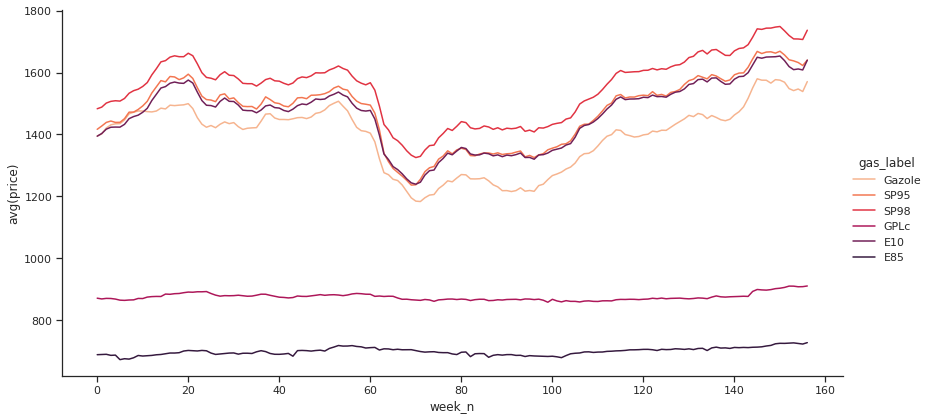

In [34]:
 #Plot the lines on two facets
graph1 = sns.relplot(
    data=aaa,
    x="week_n", y="avg(price)",
    hue="gas_label",  kind="line", palette=palette,
    height=6, aspect = 2, facet_kws=dict(sharex=False)
    )


Note that the price is in milli-euro, so the order of magnitude of average price is between 0 and 2 euros.

I also plot the average price separately to portrait the variation better

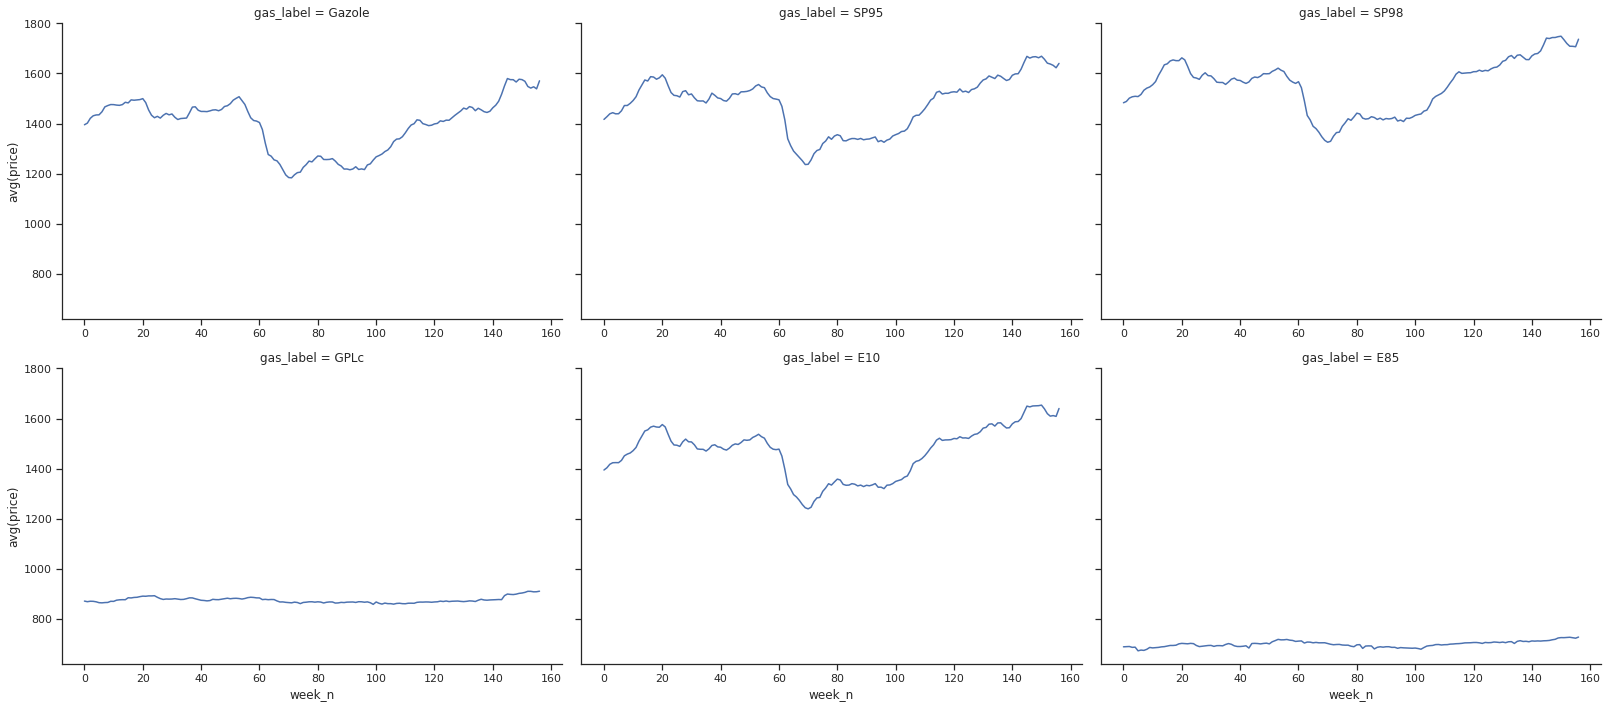

In [35]:
import seaborn as sns
sns.set_theme(style="ticks")


# Define the palette as a list to specify exact values
palette = sns.color_palette("rocket_r")

# Plot the lines on two facets
sns.relplot(
    data=aaa,
    x="week_n", y="avg(price)",
     col="gas_label",
    kind="line", palette=palette,
    height=5, aspect=1.5, facet_kws=dict(sharex=False) , col_wrap=3
)

### Data Visualization – Bonus question

- Represent a grid for each gas type of France geo heat maps of price indexes, for example at department level


First, I import the data per comune from github and I check if imported correctly. 

In [36]:
!curl -o 04-resultats-par-commune.csv.gz https://raw.githubusercontent.com/HerveMignot/geopython/main/data/04-resultats-par-commune.csv.gz


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5756k  100 5756k    0     0  2977k      0  0:00:01  0:00:01 --:--:-- 2977k


In [37]:
resultats_par_commune = spark.read.csv('04-resultats-par-commune.csv.gz', sep=',', header=True, inferSchema=True).cache()


In [38]:
resultats_par_commune.describe().show()


+-------+--------------------+------------------+------------------+--------------------+------------------+-----------------+-----------------+--------+------------------+------------+--------+------------------+------------------+-----------------+------------------+------------------+---------------------+--------------------+-----------------+-------------------+------------------+------------------+-----------------------+----------------------+------------------+--------+-----------+----------+-----------------+-------------------+---------------------+
|summary|                 url|          reg_code|        reg_code_3|            reg_name|          dep_code|     dep_code_min|       dep_code_3|dep_name|      commune_code|commune_name|num_tour|       inscrits_nb|     abstention_nb| abstention_pourc|        votants_nb|         blancs_nb|blancs_pourc_inscrits|blancs_pourc_votants|          nuls_nb|nuls_pourc_inscrits|nuls_pourc_votants|       exprimes_nb|exprimes_pourc_inscrits|exp

In [39]:
!wc -l 04-resultats-par-commune.csv.gz

29483 04-resultats-par-commune.csv.gz


Then I install and import folium and geopandas package for building map of average price by departement

In [40]:

# Install folium package
!pip install folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 51.7 MB/s eta 0:00:00


In [42]:
import folium
import geopandas
import pandas as pd

I concatenate the departement and the commune to obtain the zip code and merge later.

In [43]:
from pyspark.sql.functions import concat

In [44]:
resultats_par_commune.columns

['url',
 'reg_code',
 'reg_code_3',
 'reg_name',
 'dep_code',
 'dep_code_min',
 'dep_code_3',
 'dep_name',
 'commune_code',
 'commune_name',
 'num_tour',
 'inscrits_nb',
 'abstention_nb',
 'abstention_pourc',
 'votants_nb',
 'blancs_nb',
 'blancs_pourc_inscrits',
 'blancs_pourc_votants',
 'nuls_nb',
 'nuls_pourc_inscrits',
 'nuls_pourc_votants',
 'exprimes_nb',
 'exprimes_pourc_inscrits',
 'exprimes_pourc_votants',
 'cand_num_panneau',
 'cand_nom',
 'cand_prenom',
 'cand_civil',
 'cand_nb_voix',
 'cand_rapport_exprim',
 'cand_rapport_inscrits']

In [45]:
#Checking the number of unique zip_code to compare across file if it is coherent
ddf_index.groupby('zip_code').count().orderBy('count', ascending=False).count()

4316

In [46]:
results_df = resultats_par_commune.select(concat(resultats_par_commune.dep_code,resultats_par_commune.commune_code).alias("code"), 'url',
 'reg_code',
 'reg_code_3',
 'reg_name',
 'dep_code',
 'dep_code_min',
 'dep_code_3',
 'dep_name',
 'commune_code',
 'commune_name',
 'num_tour',
 'inscrits_nb',
 'abstention_nb',
 'abstention_pourc',
 'votants_nb',
 'blancs_nb',
 'blancs_pourc_inscrits',
 'blancs_pourc_votants',
 'nuls_nb',
 'nuls_pourc_inscrits',
 'nuls_pourc_votants',
 'exprimes_nb',
 'exprimes_pourc_inscrits',
 'exprimes_pourc_votants',
 'cand_num_panneau',
 'cand_nom',
 'cand_prenom',
 'cand_civil',
 'cand_nb_voix',
 'cand_rapport_exprim',
 'cand_rapport_inscrits')

In [47]:
#Checking the number of unique zip_code to compare across file if it is coherent

results_df.groupby('code').count().orderBy('count', ascending=False).count()

35080

In [48]:
ddf_index.groupby('zip_code').count().orderBy('count', ascending=False).count()

4316

In [49]:
results_df.show(5)

+-----+--------------------+--------+----------+--------------------+--------+------------+----------+--------+------------+--------------------+--------+-----------+-------------+----------------+----------+---------+---------------------+--------------------+-------+-------------------+------------------+-----------+-----------------------+----------------------+----------------+--------+-----------+----------+------------+-------------------+---------------------+
| code|                 url|reg_code|reg_code_3|            reg_name|dep_code|dep_code_min|dep_code_3|dep_name|commune_code|        commune_name|num_tour|inscrits_nb|abstention_nb|abstention_pourc|votants_nb|blancs_nb|blancs_pourc_inscrits|blancs_pourc_votants|nuls_nb|nuls_pourc_inscrits|nuls_pourc_votants|exprimes_nb|exprimes_pourc_inscrits|exprimes_pourc_votants|cand_num_panneau|cand_nom|cand_prenom|cand_civil|cand_nb_voix|cand_rapport_exprim|cand_rapport_inscrits|
+-----+--------------------+--------+----------+--------

In [50]:
results_df= results_df.withColumn('zip_code', results_df.code)

In [51]:
results_df.columns

['code',
 'url',
 'reg_code',
 'reg_code_3',
 'reg_name',
 'dep_code',
 'dep_code_min',
 'dep_code_3',
 'dep_name',
 'commune_code',
 'commune_name',
 'num_tour',
 'inscrits_nb',
 'abstention_nb',
 'abstention_pourc',
 'votants_nb',
 'blancs_nb',
 'blancs_pourc_inscrits',
 'blancs_pourc_votants',
 'nuls_nb',
 'nuls_pourc_inscrits',
 'nuls_pourc_votants',
 'exprimes_nb',
 'exprimes_pourc_inscrits',
 'exprimes_pourc_votants',
 'cand_num_panneau',
 'cand_nom',
 'cand_prenom',
 'cand_civil',
 'cand_nb_voix',
 'cand_rapport_exprim',
 'cand_rapport_inscrits',
 'zip_code']

In [52]:
#Joiny price data with data with some informtion on geolocalisation


result_df = results_df.join(ddf_index, on=['zip_code'], how='outer')


In [53]:
price_departments_df = (result_df
 .groupby('dep_code')
 .agg(F.avg('price_index').alias('index_price'))
 #.reset_index()
 .withColumnRenamed('dep_code','code')
)

In [54]:
price_departments_df.groupby('code').count().orderBy('count', ascending=False).count()

107

In [55]:
!curl -o departements.geojson https://raw.githubusercontent.com/HerveMignot/geopython/main/references/departements-version-simplifiee.geojson

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  555k  100  555k    0     0  1012k      0 --:--:-- --:--:-- --:--:-- 1012k


In [56]:
departements = spark.read.json('departements.geojson').cache()

In [57]:
price_departments_df = price_departments_df.toPandas()

In [ ]:
# Create a folium map
m = folium.Map(
    location=[46.5, 2.3],
    zoom_start=6,
    tiles=None,
)

# Add a map background
folium.TileLayer("CartoDB positron", name="Light Map", control=False).add_to(m)

# Draw a Choropleth layer
folium.Choropleth(
    geo_data='departements.geojson', #gdf,  #[lambda _df: _df.code.str.startswith('92')],
    data=price_departments_df,
    columns=['code', 'index_price'],  #, 'Unemployment'],
    key_on='feature.properties.code',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    #legend_name=code,
    #bins=bins,
    #reset=True
).add_to(m)

m

I try my hardest to reproduce the map but I couldn't. I can't figure out where I am getting it wrong.  

## Modeling – Option 1 – Forecast next day price

In this scenario, we use random forest regression to predict one gas type (Gazole in our case). I will be using the following label and features: 

Label → gas price
Features → {"pop", "longitude", "latitude" "previous gas price", "year", "week_of_year"}


The reasoning is to proceed by elimination of irrelevant variables, while keeping inavoidable ones. For example, day_of_week can be dropped, since their cyclality does not add much information to the price variation. 


In [59]:
from pyspark.ml.feature import StringIndexer   # str -> int
from pyspark.ml.feature import OneHotEncoder   # int -> dummy variable (may need to call a StringIndexer)
from pyspark.ml.feature import Imputer         # impute missing values according some "strategy"
from pyspark.ml.feature import StandardScaler  # normalize to [0, 1] numerical values
from pyspark.ml.feature import VectorAssembler # build a vector from several columns

from pyspark.ml.pipeline import Pipeline
from pyspark.ml.feature import HashingTF, Tokenizer



Given that price are corelated over time, I will  create the previous_week_index column from the week price (l1price) column using the windowing function called lag()

As I did exploration in the previous questions, I will focus more directly on the estimation side of things. What I mean is that I already play a lot with the data and grasp a better understanding of it during the previous questions.

In [60]:
from pyspark.sql.functions import lag


In [61]:
ddf_index1 = ddf_index.withColumn('l1price', lag('price')
                                .over(Window.partitionBy('day_only')
                                .orderBy(['id_pdv']))).filter(ddf_index.gas_label == 'Gazole')

In [70]:
ddf_index1.describe().show()

+-------+----------+-------------------+------------------+-------+-------+---------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|  day_only|             id_pdv|          zip_code|    pop| gas_id|gas_label|             price|              year|             month|      week_of_year|               day|           latitud|          longitud|         avg_price|      price_index|             day_n|            week_n|           l1price|
+-------+----------+-------------------+------------------+-------+-------+---------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|  count|   3758684|            3758684|           3758684|37

String Indexing, then one-hot encoding to encode the string/categorical columns to label indices. 

In [77]:
pop_n = StringIndexer(inputCol='pop', outputCol='n_pop')
#lag_price = Imputer(inputCol='l1price', outputCol='nm_l1price', strategy='mean')
features = VectorAssembler(inputCols=['n_pop', 'latitud', 'longitud'], outputCol='features')


In [63]:
#scaler1 = StandardScaler(inputCol='longitud', outputCol="scaled_features1")
#caler2 = StandardScaler(inputCol='latitud', outputCol="scaled_features2")

In [64]:
#pipeline = Pipeline(stages=[pop_n, features, scaler1, scaler2])

In [78]:
from pyspark.ml.regression import RandomForestRegressor

In [79]:
rf = RandomForestRegressor(featuresCol='features', labelCol='price')

Before doing any modelling (random forest regressor in our case, let's see how our pipeline transform the data. 

In [80]:
pipeline = Pipeline(stages=[pop_n, features])

I split the data into train and test as follows 8à perce"nt for the train data and 20 percent for the test data.

In [81]:
(trainingData, testData)  = ddf_index1.randomSplit((0.8, 0.2), 1234)

In [82]:
pipeline.fit(trainingData).transform(trainingData).show(8, truncate=False)

+----------+-------+--------+---+-------------------+------+---------+-----+----+-----+------------+---+------------------+------------------+------------------+------------------+-----+------+-------+-----+----------------------------------------+
|day_only  |id_pdv |zip_code|pop|date               |gas_id|gas_label|price|year|month|week_of_year|day|latitud           |longitud          |avg_price         |price_index       |day_n|week_n|l1price|n_pop|features                                |
+----------+-------+--------+---+-------------------+------+---------+-----+----+-----+------------+---+------------------+------------------+------------------+------------------+-----+------+-------+-----+----------------------------------------+
|2019-01-01|1000008|1000    |R  |2019-01-01 10:30:00|1     |Gazole   |1347 |2019|01   |1           |3  |46.199            |5.241             |1372.0615820208814|98.17343606516782 |0    |0     |null   |0.0  |[0.0,46.199,5.241]                      |
|201

Then I add the step of adding the model into the pipeline. The pipeline became pipeline_rf

In [83]:
pipeline_rf = Pipeline(stages=[pipeline, rf])

Then fit the data to the random forest regression, just for cheking 5but later we will fit it only on training data.

In [86]:
predictions = pipeline_rf.fit(testData).transform(testData)

In [91]:
df.printSchema

<bound method DataFrame.printSchema of DataFrame[day_only: string, id_pdv: int, zip_code: int, pop: string, date: timestamp, gas_id: int, gas_label: string, price: int, year: string, month: string, week_of_year: int, day: int, latitud: double, longitud: double, avg_price: double, price_index: double, day_n: int, week_n: bigint, l1price: int, n_pop: double, features: vector, prediction: double, difference: double]>

I calculate RMSE as measure of our loss function as follows (using the predictions generated in the with the test data).

In [94]:
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType

df_1 = predictions.withColumn('difference', F.col('avg_price') - F.col('prediction'))
df_2 =   df_1.withColumn('squared_difference', F.pow(F.col('difference'), F.lit(2).astype(IntegerType())))
rmse = df_2.select(F.sqrt(F.avg(F.col('squared_difference'))).alias('rmse'))

print(rmse.show())

+----------------+
|            rmse|
+----------------+
|98.6459519946392|
+----------------+

None


Our model achieved a performance of an RMSE of 99.65 which is quite good. Remember that price average is in magnitude of 1500 (milli-euro) on average. Knowing that RMSE has a same order of magnitude (unit) with the price (variable of interest), we can judge that the random forest regressor provide a good first solution. the extention of this work would be to do grid search in order to improve the model performance. The code is provided below, but given that it takes too long to run, I do not report it here.

The prediction model achieved an RMSE 

In [95]:
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import RegressionMetrics

In this part, I perform gridsearch to look for an optimal model (with optimal parameters achieving the smallest loss in a set of loss function) , by defining a grid of parameter for the model training. We define a RegressionEvaluator, which will evaluate the model by comparing the test value (price) to the prediction based on crossValidator.

In [ ]:
#paramGrid = ParamGridBuilder().addGrid(rf.maxBins, [10, 50, 150]).addGrid(rf.maxDepth, [3, 6, 10]).addGrid(rf.numTrees, [5, 20]).build()

In [96]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
#crossval = CrossValidator(estimator=pipeline,
 #                         estimatorParamMaps=paramGrid,
  #                         evaluator=RegressionEvaluator(),
   #                       numFolds=2)

In [ ]:
 #evaluator = RegressionEvaluator().setLabelCol("price").setPredictionCol("prediction").setMetricName("rmse")

In [ ]:
#pipelineModel = crossval.fit(ddf_index1)

In [ ]:
#crossval.estimatorParamMaps()